<a href="https://colab.research.google.com/github/parksoy/Common_Snippets_Python/blob/master/building_an_end_to_end_nlp_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an end-to-end NLP application
from https://medium.com/mlearning-ai/building-an-end-to-end-nlp-application-an-overview-ef0221c4ab1f

This notebook will demonstrate the generic steps involved in solving a text classification problem. For the purpose of the demostration, we'll look at a binary classification problem (specifically sentiment analysis) and go through all the stages of typical ML lifecycle.

- **Problem:** Sentiment analysis (supervised)
- **Dataset:** Amazon product reviews
- **Framework for model building:** TensorFlow, HuggingFace Transformers
- **Demo:** Gradio


In [28]:
# Set the session to use GPU
import tensorflow as tf
import os
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
assert num_gpus_available > 0

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
os.environ["CUDA_VISIBLE_DEVICES"]='0'

Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [29]:
# Install necessary libraries
!pip install gradio
!pip install transformers
!pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## ML Workflow

The following are the stages involved in building any typical ML solution.

- **Stage 1:** Gather data
- **Stage 2:** Explore the data
    - **Stage 2.5:** Choose a model
- **Stage 3:** Prepare the data
- **Stage 4:** Build, train and evaluate the model
- **Stage 5:** Refine the model
- **Stage 6:** Deploy the model

### Stage 1: Gather data

This is one of the most important step in solving any supervised ML problem. Remember, the model is as good as your data. For the problem you're trying to solve, sometimes, the data might be available but in most of the real-world scenarios, data will not be readily available. In such scenarios, here are some of the things to keep in mind while collecting data,

- Check if there is a public API available to get the data. Understand the limitations, pricing, number of tries etc. of the API.
- More the data, the better the model will be.
- Make sure you have enough samples for each of the target classes. 
- The samples should adequately cover the space of possible inputs to your problem.


In [30]:
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [31]:
# Load the tensorflow dataset
dataset = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split='train', shuffle_files=True)

### Stage 2: Explore the data

Before trying to build a model, it is imperative to understand the data at hand. Understanding the charateristics of the data will not only help in picking the right modeling technique for the problem we're trying to solve but also helps in building better models with good quality data. 

Always inspect some randon samples of data and get some key metrics like,

- Total number of samples available
- Number of classes/targets
- Total samples available per class
- Number of words per sample
- Frequency distribution of words
- Distribution od sample length

In [32]:
# Convert the dataset to pandas dataframe
dataset = tfds.as_dataframe(dataset)
dataset.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1
3,b'27389005',0,b'US',b'Mobile_Electronics',b'B008L3JE6Y',b'466340015',b'High Grade Robust 360\xc2\xb0 Adjustable Car...,b'This product was purchased to hold a monitor...,b'2013-07-30',b'camera stand',b'R1TWVUDOFJSQAW',5,0,0,1
4,b'2663569',0,b'US',b'Mobile_Electronics',b'B00GHZS4SC',b'350592810',b'HDE Multifunctional Bluetooth FM Audio Car K...,"b""it works but it has really bad sound quality...",b'2014-12-31',b'bad sound quality',b'R2PEOEUR1LP0GH',3,0,0,1


In [33]:
# Pick the relevant columns of interest
columns_of_interest = ['data/review_body', 'data/star_rating']
data = dataset[columns_of_interest]
data.head()

,data/review_body,data/star_rating
0,b'Does not work',1
1,b'This is a great wiring kit i used it to set ...,4
2,b'It works great so much faster than USB charg...,5
3,b'This product was purchased to hold a monitor...,5
4,"b""it works but it has really bad sound quality...",3


In [34]:
# Get the number of samples
print("Total number of datapoints:", data.shape[0])

Total number of datapoints: 104975


In [35]:
# Get the number of class (we will convert this the rating to sentiment in the next stage)
print("Number of classes:", data['data/star_rating'].nunique())

Number of classes: 5


In [36]:
# Get the number of samples per class
print("Number of samples per class: \n" ,data['data/star_rating'].value_counts())

Number of samples per class: 
 5    52255
4    18088
1    17587
3     9734
2     7311
Name: data/star_rating, dtype: int64


In [37]:
# Get the number of words per sample
print("Number of words per sample: " ,np.mean(data['data/review_body'].apply(lambda x: len(x.split()))))

Number of words per sample:  63.97938556799238


In [38]:
# Get the distribution of number of words per sample
print("Distribution of number of words per sample:")
pd.DataFrame([len(s) for s in data['data/review_body']]).value_counts()

Distribution of number of words per sample:


9        550
114      534
115      523
113      522
119      518
        ... 
2724       1
2729       1
2731       1
2732       1
16009      1
Length: 3079, dtype: int64

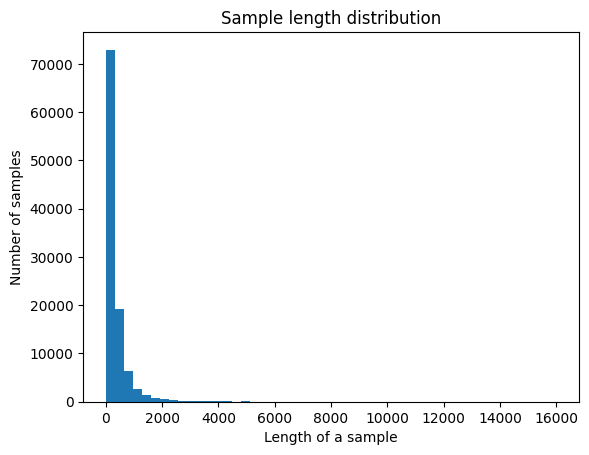

In [39]:
# Plot the distribution of of sample length
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """

    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

plot_sample_length_distribution(data['data/review_body'].tolist())

#### Stage 2.5: Choose a model

The data exploration we performed in the previous stage helps us in answering the following questions,

- **Which model to choose?** - If the data is less and we have enough representation per class, going for a simple MLP or ML model would suffice. If you have enough data and there is no pretrained model for that domain, you can train a sequence model from scratch. If you find  pre-trained models in a particular domain and you want to apply it to a similar domain data where you have just enough data, then choose transfer learning.

- **How do we prepare the data efficiently?** - Based on the model we choose, the type of preprocessing changes. If we choose a simple MLP or ML model, we perform vectorization using bag of words after appropriate preprocessing. For sequence models, we may need to preserve the context of the data, so we will go for embeddings like word2vec, sentenece embeddigns etc.

### Stage 3: Prepare the data

Data should be converted to a form that the model can understand. Data preparation involves two steps,

- **Feature engineering:**
Feature engineering involves creating or extracting features out of the textual data so that it can be fed into the model. There are two steps that needs to be done while extracting features, 

    1. **Tokenization:** Converting the texts into smaller units like words(tokens) or n-grams. Based on the unique tokens, a dictionary will be created, which forms the vocabulary for the given dataset.

    2. **Vectorization:** Converting the textual data into numbers using the vocabulary. Some common techniques used for vectorizations are one-hot encoding (based on the presence or absence of a token), count encoding (based on the number of occurance of a token), and Tf-idf encoding (based on weights assigned to the frequency of occurance of tokens across the documents).

- **Feature Selection:** 
Once the features are created, we can carefully select relevant features using feature importance through some statistical measure. Using the right features, both in terms of quantity and quality will help in building better models.

#### Important points to remember: 
- Always make sure that the data is shuffled and sampled.
- Split the data into train, test and validation splits.
- Save the vectorizer after vectorizing the training data and use it to transform the test data.

In [40]:
# Take a sample of 50% of the dataset for the purpose of demonstration
data = data.sample(frac=0.3, random_state=42)
data.head()

,data/review_body,data/star_rating
87666,"b""The motor spins and is not stationary. That ...",3
47509,b'Fake',1
69877,"b""Even though there are finally some silicone ...",5
11951,"b""Absolutely Wonderful: This product is every...",5
73562,"b""Love this Bluetooth speaker...easy setup, wo...",5


In [41]:
print("Number of datapoints after samplig:", data.shape)

Number of datapoints after samplig: (31492, 2)


In [42]:
# Convert the star rating to sentiment
data['sentiment'] = data['data/star_rating'].apply(lambda rating: "positive" if rating >= 3 else "negative")
data.head()

,data/review_body,data/star_rating,sentiment
87666,"b""The motor spins and is not stationary. That ...",3,positive
47509,b'Fake',1,negative
69877,"b""Even though there are finally some silicone ...",5,positive
11951,"b""Absolutely Wonderful: This product is every...",5,positive
73562,"b""Love this Bluetooth speaker...easy setup, wo...",5,positive


In [43]:
# One-hot encode the target label
data['sentiment'] = data['sentiment'].map({'positive':1, 'negative':0})

# Drop the rating column
data.drop(columns=['data/star_rating'], inplace=True)
data.head()

,data/review_body,sentiment
87666,"b""The motor spins and is not stationary. That ...",1
47509,b'Fake',0
69877,"b""Even though there are finally some silicone ...",1
11951,"b""Absolutely Wonderful: This product is every...",1
73562,"b""Love this Bluetooth speaker...easy setup, wo...",1


In [44]:
# Preprocess the reviews
data.rename(columns={'data/review_body': 'review'}, inplace=True)
data['review'] = data['review'].str.decode('utf-8')
data['review'] = data["review"].apply(str.lower)
data['review']

data.head()

,review,sentiment
87666,the motor spins and is not stationary. that se...,1
47509,fake,0
69877,even though there are finally some silicone ca...,1
11951,absolutely wonderful: this product is everyth...,1
73562,"love this bluetooth speaker...easy setup, wond...",1


In [45]:
# Check the samples per class
data['sentiment'].value_counts()

1    24067
0     7425
Name: sentiment, dtype: int64

In [46]:
# Balance out the classes for the purpose of demonstration
positive = data[data['sentiment'] == 1].sample(n=7425, random_state=42)
negative = data[data['sentiment'] == 0]
train_data = pd.concat([positive, negative]).sample(frac=1).reset_index(drop=True)
train_data['sentiment'].value_counts()

0    7425
1    7425
Name: sentiment, dtype: int64

In [47]:
# Sample reviews and its corresponding labels
reviews = train_data['review'].tolist()
labels = train_data['sentiment'].tolist()

print("Sample reviews:")
print(reviews[10:16])
print("Corresponding labels:")
print(labels[10:16])

Sample reviews:
['was a little leery of this when i purchased.  the price was very low and i had never heard of the brand.  it is for my wife\'s new nano 5th generation, and she wanted one with a sturdy clip on the case.  the ones with clips turned out to be harder to find than i thought unless you wanted one that was an armband.  ordered the \\\\"hot pink flip\\\\" case....to match the hot pink nano.  case arrived within 4 days.  it seems very well made and the screen protector makes the $6.95 price tag a real bargain.  it fits the 5th gen nano perfectly.  the video camera has a perfectly placed cutout, and the clip is quite sturdy.  don\'t hesitate if you are considering this one.....very happy with it.', 'great case for my new nook.  i had no problems turning pages or turning on and off.  i love it.', 'they do not work. i ordered the right pair for my model. i would like to replace them for a working pair.', 'the uniden bct8 trunking scanner took away all the frustration i had attem

In [48]:
# Split the data into train, test and vvalidation split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(reviews, labels, test_size=.2, random_state=42)

In [49]:
# Number of train and test data
print("Number of train data points:", len(X_train))
print("Number of train labels:", len(y_train))
print("Number of test data points:", len(X_test))
print("Number of test labels:", len(y_test))

Number of train data points: 11880
Number of train labels: 11880
Number of test data points: 2970
Number of test labels: 2970


In [50]:
# Load the tokenizer
from transformers import DistilBertTokenizerFast
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

In [51]:
# Sample tokenization
print("Sentence:" , X_train[0])
tokenizer(X_train[0], truncation=True, padding=True, max_length=256, return_tensors="tf")

Sentence: outstanding replacement lcd.  followed the online video instruction and saved our nuvi 2455 from the trash heap.


{'input_ids': <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
array([[  101,  5151,  6110, 27662,  1012,  2628,  1996,  3784,  2678,
         7899,  1998,  5552,  2256, 16371,  5737, 21005,  2629,  2013,
         1996, 11669, 16721,  1012,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]], dtype=int32)>}

In [52]:
# Perform tokenization
MAX_LENGTH=256
train_encodings = tokenizer(X_train,
                            truncation=True, 
                            padding=True,
                            return_tensors="tf",
                            max_length=MAX_LENGTH)
test_encodings = tokenizer(X_test,
                           truncation=True, 
                           padding=True,
                           return_tensors="tf",
                           max_length=MAX_LENGTH)

In [53]:
# Convert the tokenizer to TF object
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                   y_test))

### Stage 4: Build, train and evaluate the model

For the purpose of demonstration, transfer learning is used for building the model for the sentiment analysis task at hand. We'll be using a pretrained distilbert model that's finetuned on SST-2 (Stanford Sentiment Treebank v2) dataset. More details on the model can be found here: https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

The following key parameters need to be thought through before we build any model,

- **Metric:** How do we measure the performance of the model? What should be the right metric? - Accuracy can be used here.

- **Loss function:** It is the objective function that is learned during training. And a good model should always try to minimize the loss function. For classification problems, cross-entropy loss can be used as the objective or loss function.

- **Optimizer:** A function that decides how the network weights will be updated based on the output of the loss function.

In [54]:
# Define the model - use pretrained distilbert model and specify the label
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    num_labels=2
    )

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [55]:
# Specify the model optimizer
optimizer = tf.keras.optimizers.Adam(
            learning_rate=5e-5, 
        )

In [56]:
# Specify the loss function
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [57]:
# Compile the model

model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

In [58]:
# Inspect the model
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Define hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 2

# Train the model
model.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE),
          epochs=NUM_EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE)
          )

Epoch 1/2
743/743 [==============================] - 374s 455ms/step - loss: 0.2691 - accuracy: 0.8922 - val_loss: 0.2588 - val_accuracy: 0.8933
Epoch 2/2
743/743 [==============================] - 341s 460ms/step - loss: 0.1482 - accuracy: 0.9455 - val_loss: 0.2661 - val_accuracy: 0.9054


In [60]:
# Save the model
model.save_pretrained("/tmp/sentiment_model")

In [61]:
# Preprocess the unseen data
unseen_data = data.sample(frac=0.05, random_state=42)
unseen_reviews = unseen_data['review'].tolist()

unseen_encodings = tokenizer(unseen_reviews,
                            padding=True,
                            truncation=True,
                            max_length=MAX_LENGTH,
                            return_tensors="tf")

y_unseen = unseen_data['sentiment'].tolist()

unseen_encodings = tf.data.Dataset.from_tensor_slices((dict(unseen_encodings),
                                                       y_unseen
                                                      ))


In [62]:
# Evaluate the model
model.evaluate(unseen_encodings.shuffle(len(unseen_reviews)).batch(BATCH_SIZE),
               return_dict=True,
               batch_size=BATCH_SIZE)

99/99 [==============================] - 14s 144ms/step - loss: 0.1877 - accuracy: 0.9295


{'loss': 0.18766123056411743, 'accuracy': 0.9295238256454468}

### Stage 5: Refine the model

Once the model is built and trained, the result may not be satisfactory at times (we may not get expected performance from the model). The model may overfit or underfit depending on several factors. In order to improve the model, we can perfrom hyperparameter tuning. Some of the hyperparameters are the following,

- Number of layers in the model (hidden layers) - too many layers can result in overfitting and too few layers will result in underfitting.
- Number of units per layer - input layer should match the input size, and number of units in the hidden layer can be decided based on how do you wnat to respesent the data.
- Dropout rate - to penalize the model from overfitting.
- Learning rate - how fast the network should converge to the optimal values of the weights.

You can try different configurations for the hyperparameters and see what works best for your model.

### Stage 6: Deploy the model

There are several options to deploy a model. You can also optimize the trianed model using quantization methods in order to deploy it in a resource constrained environment. Some of the available options are,

1. [TensorFlow serving](https://www.tensorflow.org/tfx/guide/serving)
2. [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/common/production_inference.html)
3. Convert to [ONNX](https://onnx.ai/) format and choose the framework of your choice
4. [Dockerize](https://www.docker.com/) your model and deploy using any REST API framework like [FastAPI](https://fastapi.tiangolo.com/) or [Flask with Gunicorn](https://dev.to/brandonwallace/deploy-flask-the-easy-way-with-gunicorn-and-nginx-jgc)

Your job doesn't end there!! 
- You'll have to monitor your model for any performace degradation and drifts (model or data) while it is in production. Do the check regularly.
- Collect more data while the model is in production through feedback.
- If you find that the model is degrading, then you will have to retrain your model using the data collected from feedback.


For the purpose of this demostration, let's look at how to use notebook as an interface to get predictions using Gradio.



In [64]:
import gradio as gr

def predict(sentence):
    # Load model
    loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/tmp/sentiment_model")

    # Get the prediction
    predict_input = tokenizer.encode(sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

    tf_output = loaded_model.predict(predict_input)[0]
    tf_prediction = tf.nn.softmax(tf_output, axis=1).numpy()[0]
    return ['negative', 'positive'][np.argmax(tf_prediction)]

demo = gr.Interface(fn=predict, inputs="text", outputs="text",live=False)

demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2a99b51-b274-4e57-b790-07263784107d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>